In [377]:
import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from src import load_img, select_points
import os

In [378]:
path_2d = "./data/2d_points_12.npy"
path_3d = "./data/3d_points_more.csv"

points_3d = pd.read_csv("./data/3d_points_more.csv", index_col=0)
description = points_3d["desc"].values
points_3d = points_3d.values[:, 1:].astype(np.float32)
""" points_2d = np.array([[497,673],
                      [399, 295],
                      [465, 357],
                      [595, 361],
                      [664, 430],
                      [735, 535],
                      [813, 611],
                      [758, 280],
                      [932, 588]]) """

' points_2d = np.array([[497,673],\n                      [399, 295],\n                      [465, 357],\n                      [595, 361],\n                      [664, 430],\n                      [735, 535],\n                      [813, 611],\n                      [758, 280],\n                      [932, 588]]) '

In [379]:
def load_img(path):
    img = Image.open(path)
    w, h = img.size
    new_size = (w // 4, h // 4)
    img.thumbnail(new_size)
    return img

img = load_img("./data/CALIB_ALEX_VEIKKA.png")
def select_points(img):
    """
    Function to select points from an image.

    If you selected all the points you wanted, press ESC or close the window.
    """

    points = []

    img = np.array(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # load reference
    reference = load_img("./data/CALIB_ALEX_VEIKKA_SETUP.jpg")
    reference = np.array(reference)
    reference = cv.cvtColor(reference, cv.COLOR_BGR2RGB)
    # clip reference
    reference = cv.resize(reference, (img.shape[1], img.shape[0]))
    reference = reference[:, 350:]
    reference = reference[:, :650]

    img = np.concat((img, reference), 1)
    def click_event(event, x, y, flags, param):
        nonlocal points
        if event == cv.EVENT_LBUTTONDOWN:
            cv.circle(param, (x, y), 4, (255, 0, 255), -1)
            cv.imshow("Image", param)
            points.append((x, y))
            

    cv.imshow("Image", img)
    cv.setMouseCallback("Image", click_event, img)

    while True:
        key = cv.waitKey(20) & 0xFF
        if key == 27:  # ESC key to break
            break
        if (
            cv.getWindowProperty("Image", cv.WND_PROP_VISIBLE) < 1
        ):  # Check if window is closed
            break
    cv.destroyAllWindows()

    return np.stack(points)
if os.path.exists("./data/2d_points_12.npy"):
    points_2d = np.load("./data/2d_points_12.npy")
else:
    points_2d = select_points(img)
    np.save("./data/2d_points_12.npy", points_2d)

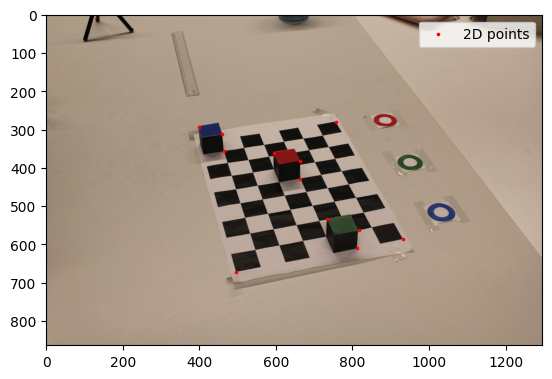

In [380]:
plt.imshow(img)
plt.scatter(points_2d[:, 0], points_2d[:, 1], color='red', marker='.', s=10, label='2D points')
plt.legend()


In [381]:
def calibrate(points2d, points3d, normalize=False):
    # Implement a direct linear transformation (DLT) algorithm to calibrate the camera.

    # Convert the 2D & 3D points to homogeneous coordinates
    points2d = np.hstack((points2d, np.ones((points2d.shape[0], 1))))
    points3d = np.hstack((points3d, np.ones((points3d.shape[0], 1))))

    if normalize:
        # Nomalize the 2D points
        x_mean = np.mean(points2d[:, 0])
        y_mean = np.mean(points2d[:, 1])
        d_bar = np.mean(
            np.sqrt((points2d[:, 0] - x_mean) ** 2 + (points2d[:, 1] - y_mean) ** 2)
        )
        S = np.sqrt(2) / d_bar
        T = np.array([[S, 0, -S * x_mean], [0, S, -S * y_mean], [0, 0, 1]])
        points2d = np.dot(T, points2d.T).T

        # Normalize the 3D points
        x_mean = np.mean(points3d[:, 0])
        y_mean = np.mean(points3d[:, 1])
        z_mean = np.mean(points3d[:, 2])
        d_bar = np.mean(np.sqrt((points3d[:, 0] - x_mean) ** 2 + (points3d[:, 1] - y_mean) ** 2 + (points3d[:, 2] - z_mean) ** 2))
        S = np.sqrt(3) / d_bar
        U = np.array(
            [
                [S, 0, 0, -S * x_mean],
                [0, S, 0, -S * y_mean],
                [0, 0, S, -S * z_mean],
                [0, 0, 0, 1],
            ]
        )
        points3d = np.dot(U, points3d.T).T

    # Create the matrix A
    A = np.zeros((2 * points2d.shape[0], 12))
    for i in range(points2d.shape[0]):
        A[2 * i, 0:4] = points3d[i, :]
        A[2 * i, 8:12] = -points2d[i, 0] * points3d[i, :]
        A[2 * i + 1, 4:8] = points3d[i, :]
        A[2 * i + 1, 8:12] = -points2d[i, 1] * points3d[i, :]

    # Solve the linear system of equations Am = 0
    _, _, V = np.linalg.svd(A)
    m = V[-1, :].reshape((3, 4))

    if normalize:
        # Denormalize the camera matrix
        m = np.linalg.inv(T) @ m @ U
    #m = m / m[2, 3]  # Normalize the camera matrix s.t. m[2, 3] = 1
    return m

In [382]:
#def calibrate(points2d, points3d):
#    """
#    Performs direct linear transform (DLT)
#
#    Instead of using SVD, we solve min(|Am + [x, y]|²),
#    because lecture material gives the constraint m(3, 4) = 1.
#    Now, numpy.linalg.lstsq is used to solve the system.
#    Having constraint |m|_2 = 1, we could use SVD to solve
#    all the parameters of M.
#    """
#
#    n = len(points3d)
#    biased = np.concat((points3d, np.ones((n, 1))), 1)
#
#    top_left = np.concat((biased, np.zeros((n, 4))), 1)
#    bot_left = np.roll(top_left, 4, axis=1)
#
#    top_right = -biased * points2d[:, 0:1]
#    bot_right = -biased * points2d[:, 1:2]
#
#    system = np.concat(
#        (np.concat((top_left, top_right), 1), np.concat((bot_left, bot_right), 1)), 0
#    )
#
#    m, _, _, _ = np.linalg.lstsq(system[:, :-1], -system[:, -1])
#    M = np.append(m, 1).reshape(3, 4)
#
#    return M
#
#
#def calibrate_norm(points2d, points3d):
#    """DLT woth normalization"""
#
#    x_hat, y_hat = points2d.mean(0)
#    d_hat = np.linalg.norm(points2d - np.array([x_hat, y_hat]), 1).mean()
#
#    X_hat, Y_hat, Z_hat = points3d.mean(0)
#    D_hat = np.linalg.norm(points3d - np.array([X_hat, Y_hat, Z_hat]), 1).mean()
#
#    root2 = np.sqrt(2)
#    root3 = np.sqrt(3)
#
#    T = np.array(
#        [
#            [root2 / d_hat, 0, -root2 * x_hat / d_hat],
#            [0, root2 / d_hat, -root2 * y_hat / d_hat],
#            [0, 0, 1],
#        ]
#    )
#
#    U = np.array(
#        [
#            [root3 / D_hat, 0, 0, -root3 * X_hat / D_hat],
#            [0, root3 / D_hat, 0, -root3 * Y_hat / D_hat],
#            [0, 0, root3 / D_hat, -root3 * Z_hat / D_hat],
#            [0, 0, 0, 1],
#        ]
#    )
#
#    normalized_2d_pts = points2d * np.diag(T)[:-1] + T[:-1, -1]
#    normalized_3d_pts = points3d * np.diag(U)[:-1] + U[:-1, -1]
#
#    M = calibrate(normalized_2d_pts, normalized_3d_pts)
#    denormalized_M = np.linalg.inv(T) @ M @ U
#
#    return denormalized_M

In [383]:
m = calibrate(points_2d, points_3d)
points_3d_hom = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
points_2d_calibrated = (m @ points_3d_hom.T).T
points_2d_calibrated = points_2d_calibrated[:, :2] / points_2d_calibrated[:, 2].reshape(
    -1, 1
)

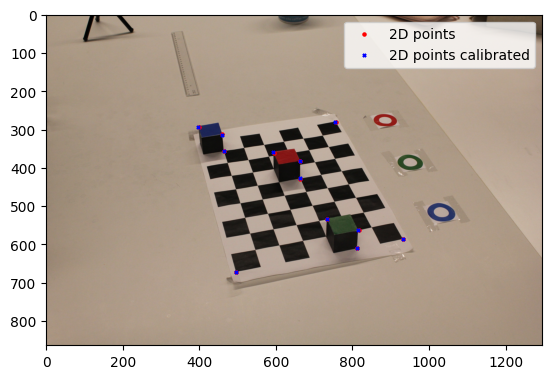

In [384]:
plt.imshow(img)
plt.scatter(points_2d[:, 0], points_2d[:, 1], color='red', marker='.', s=20, label='2D points')
plt.scatter(points_2d_calibrated[:, 0], points_2d_calibrated[:, 1], color='blue', marker='x', s=5, label='2D points calibrated')
plt.legend()
plt.show()

In [385]:
def plot_frame(ax, T, name=""):
    """Function that plots the world frames"""
    # Origin
    l = 100
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 0], T[1, 0], T[2, 0], color="r", length=l)
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 1], T[1, 1], T[2, 1], color="g", length=l)
    ax.quiver(T[0, 3], T[1, 3], T[2, 3], T[0, 2], T[1, 2], T[2, 2], color="b", length=l)

    ax.text(
        T[0, 3] + T[0, 0] * l, T[1, 3] + T[1, 0] * l, T[2, 3] + T[2, 0] * l, f"{name}X"
    )
    ax.text(
        T[0, 3] + T[0, 1] * l, T[1, 3] + T[1, 1] * l, T[2, 3] + T[2, 1] * l, f"{name}Y"
    )
    ax.text(
        T[0, 3] + T[0, 2] * l, T[1, 3] + T[1, 2] * l, T[2, 3] + T[2, 2] * l, f"{name}Z"
    )

    ax.set_aspect("equal", adjustable="box")

In [386]:
from scipy.linalg import rq
def decompose_projection(M):
    # implement the decomposition
    X = np.linalg.det([M[:, 1], M[:, 2], M[:, 3]])
    Y = -np.linalg.det([M[:, 0], M[:, 2], M[:, 3]])
    Z = np.linalg.det([M[:, 0], M[:, 1], M[:, 3]])
    W = -np.linalg.det([M[:, 0], M[:, 1], M[:, 2]])

    C = np.array([[X, Y, Z]]).T / W
    K, R = rq(M @ np.linalg.pinv(np.hstack([np.eye(3), -C])))
    # rq decomposition can throw a weird result, this make sure that the result is valid for our purposes
    R = R * np.sign(K[-1, -1])
    K = K * np.sign(K[-1, -1])

    return K, R, C


def plot_projection(points, ax=None):
    """Function that plots the projection of the points in 3D space"""
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    else:
        ax = ax
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="blue", marker=".")

    
    ax.set_aspect("equal", adjustable="box")

In [387]:
M = m  # use the matrix created in Task 1
K, R, C = decompose_projection(M)

M_reconstructed = K @ R @ np.hstack([np.eye(3), -C])




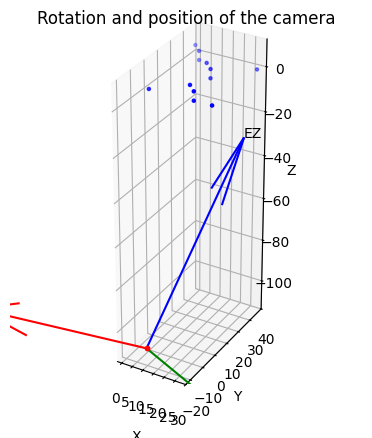

In [388]:
fig = plt.figure(figsize=(10, 5))
extrinsic_params = np.hstack([R, -R @ C])

ax1 = fig.add_subplot(121, projection="3d")
ax1.set_title("Rotation and position of the camera")
ax1.grid(True)

plot_frame(ax1, extrinsic_params, "E")
plot_projection(points_3d, ax=ax1)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.scatter(*-R@C, color="red", marker="o", s=10, label="Camera position")

plt.show()